# Reviewing respiration measurements
Assess the range of respiratory behaviour caught in individual recordings and evaluate strategies for normalising measurements to be comparable between recordings and participants. 

    1. Review respiration from one participant over: whole concert, whole recording, whole week of recordings.
    2. Considering Inspiration depth and regularity: how clearly is this extractable? Does characteristic quiet breathing depth vary substantially over recordings time?
    3. Develope compensation strategy to bring inpsiratoin during quiet breathing to a value of 1, consistent over time. 

In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json 
from scipy.signal import butter, filtfilt, argrelextrema
from scipy import interpolate
from scipy.interpolate import interp1d

import activityanalysis_test as act
import respy_test as respy

In [2]:
%load_ext autoreload
%autoreload 1
%aimport eq
%aimport qex
%aimport al
%aimport respy

In [3]:
%reload_ext autoreload

# Load data

In [9]:
Piece_timings = pd.read_csv('../Data/Timing/Concerttimes_Seconds.csv')
PartDets = pd.read_csv('../Data/Participants/Participant_Metadata_stage.csv',index_col=0)
player_order = ['VN102','VN107','VN106','VN108','VN101','VN105','VN103','VN104',
                'VN205','VN203','VN202','VN206','VN209','VN210','VN207','VN208','VN201','VN204',
                'VA305','VA307','VA308','VA301','VA306','VA302','VA303','VA304',
                'LS406','LS407','LS408','LS405','LS401','LS403','LS402','LS410','LS404',
                'WW505','WW502','WW503','WW506','WW501','WW504','WW507',
                'BR604','BR603','BR602','BR606','BR607','BR605','BR601',
                'PC704','PC705','PC703','PC701','PC702','PC707']
Dets=PartDets.loc[player_order,['Section', 'Instrument', 'Stage_X', 'Stage_Y']].copy()

In [10]:
Players_Resp = {}
Players_Resp['RD'] = ['VN102','VN107','VN108','VN101','VN105','VN103','VN104',
                'VN205','VN203','VN206','VN210','VN207','VN208','VN201','VN204',
                'VA305','VA307','VA308','VA301','VA306','VA302','VA303','VA304',
                'LS406','LS407','LS408','LS405','LS401','LS403','LS402','LS410','LS404',
                'WW505','WW502','WW503','WW506','WW501','WW504','WW507',
                'BR604','BR603','BR602','BR606','BR607','BR605','BR601',
                'PC704','PC705','PC703','PC701','PC702','PC707']
Players_Resp['C1'] = ['VN102','VN107','VN108','VN101','VN105','VN103','VN104',
                'VN205','VN203','VN202','VN206','VN209','VN210','VN207','VN208','VN201','VN204',
                'VA305','VA307','VA308','VA301','VA306','VA302','VA303','VA304',
                'LS406','LS407','LS408','LS405','LS401','LS403','LS402','LS410','LS404',
                'WW505','WW502','WW503','WW506','WW501','WW504','WW507',
                'BR604','BR603','BR602','BR606','BR607','BR605','BR601',
                'PC704','PC705','PC701','PC702','PC707']
Players_Resp['C2'] = ['VN102','VN107','VN108','VN101','VN105','VN103','VN104',
                'VN205','VN203','VN202','VN206','VN209','VN210','VN207','VN208','VN201','VN204',
                'VA305','VA307','VA308','VA301','VA302','VA303','VA304',
                'LS406','LS407','LS408','LS405','LS401','LS403','LS402','LS410','LS404',
                'WW505','WW502','WW503','WW506','WW501','WW504','WW507',
                'BR604','BR603','BR602','BR606','BR607','BR605','BR601',
                'PC704','PC705','PC701','PC702','PC707']
Players_Resp['C3'] = ['VN102','VN107','VN108','VN101','VN105','VN103','VN104',
                'VN205','VN203','VN202','VN206','VN209','VN210','VN207','VN208','VN201','VN204',
                'VA305','VA307','VA301','VA306','VA302','VA304',
                'LS406','LS407','LS408','LS405','LS401','LS403','LS402','LS410','LS404',
                'WW505','WW502','WW503','WW506','WW507',
                'BR604','BR602','BR606','BR607','BR605','BR601',
                'PC704','PC705','PC701','PC702','PC707']
Players_Resp['C4'] = ['VN102','VN107','VN108','VN101','VN105','VN103','VN104',
                'VN205','VN203','VN202','VN206','VN209','VN210','VN207','VN208','VN201','VN204',
                'VA305','VA307','VA301','VA306','VA302','VA304',
                'LS406','LS407','LS408','LS405','LS401','LS403','LS402','LS410','LS404',
                'WW505','WW502','WW503','WW506','WW501','WW504','WW507',
                'BR604','BR602','BR606','BR607','BR605','BR601',
                'PC704','PC705','PC701','PC702','PC707']
Players_Resp['C5'] = ['VN102','VN107','VN108','VN101','VN105','VN103','VN104',
                'VN205','VN203','VN202','VN206','VN209','VN210','VN207','VN208','VN201','VN204',
                'VA307','VA301','VA302','VA304',
                'LS406','LS407','LS408','LS405','LS401','LS403','LS402','LS410','LS404',
                'WW505','WW502','WW506','WW501','WW504','WW507',
                'BR604','BR602','BR606','BR607','BR605','BR601',
                'PC704','PC703','PC701','PC702','PC707']

In [11]:
concert_loc = {
    'RD':'../Data/AlignedPhys/20230215_RD/Full/',
    'C1':'../Data/AlignedPhys/20230216_C1/Full/',
    'C2':'../Data/AlignedPhys/20230216_C2/Full/',
    'C3':'../Data/AlignedPhys/20230217_C3/Full/',
    'C4':'../Data/AlignedPhys/20230217_C4/Full/',
    'C5':'../Data/AlignedPhys/20230218_C5/Full/'}

concerts = list(concert_loc.keys())

In [12]:
datafile_type = 'EQRESP'
concert = 'C1'
piece = 'Full'
data_loc = concert_loc[concert]# '../Data/AlignedPhys/20230215_C1/' + piece + '/'
files = os.listdir(data_loc)
files.sort()
sig_files = {}
for f in files: 
    if f.endswith(datafile_type+'.csv'): 
        partID = f.split('_')[2]
        sig_files[partID] = data_loc+f
        
sigName = 'Breathing'
C_times = Piece_timings[['Event','Event_Type','Related',concert]].sort_values(concert)
C_times = C_times.loc[C_times[concert]>-15,:].reset_index(drop = True).copy()
C_times

,Event,Event_Type,Related,C1
0,Synch Taps,Orch,Init,0.000
1,Applause for Conductor,Applause,Init,28.292
2,Saevarud,Music,Saev,44.900
3,Applause for Saevarud,Applause,Saev,279.156
4,MC pre Reich,Speech,Reic,294.284
5,Reich,Music,Reic,723.922
6,Applause for Reich,Applause,Reic,830.074
7,MC pre Arban,Speech,Arba,842.650
8,Applause for Florian,Applause,Arba,963.502
9,Arban,Music,Arba,982.114


In [14]:
datafile_type = 'EQRESP'
concert = 'C5'
piece = 'Full'
data_loc = concert_loc[concert]# '../Data/AlignedPhys/20230215_C1/' + piece + '/'
files = os.listdir(data_loc)
files.sort()
sig_files = {}
for f in files: 
    if f.endswith(datafile_type+'.csv'): 
        partID = f.split('_')[2]
        sig_files[partID] = data_loc+f
        
sigName = 'Breathing'
C_times = Piece_timings[['Event','Event_Type','Related',concert]].sort_values(concert)
C_times = C_times.loc[C_times[concert]>-15,:].reset_index(drop = True).copy()
C_times

,Event,Event_Type,Related,C5
0,Synch Taps,Orch,Init,0.000
1,Saevarud,Music,Saev,15.336
2,Applause for Saevarud,Applause,Saev,246.166
3,MC pre Reich,Speech,Reic,257.826
4,Reich,Music,Reic,694.972
5,Applause for Reich,Applause,Reic,802.967
6,MC pre Arban,Speech,Arba,813.700
7,Applause for Florian,Applause,Arba,997.015
8,Arban,Music,Arba,1012.486
9,Applause for Arban,Applause,Arba,1520.986


In [20]:
partID = 'VN102'
V = pd.read_csv(sig_files[partID])
1/V.loc[:,'c_sTime'].diff().median()

25.641025641034012

In [29]:
sf = 25 # hz 
cutoff = 2 #cutoff = np.array([0.05,1]) 
nyq = 0.5 * sf 
order = 2 
normal_cutoff = cutoff / nyq
b, a = butter(order, normal_cutoff, btype='lowpass', analog=False)

s_time = -15 #C_times.loc[0,concert]
e_time = C_times[concert].iloc[-1]
dur = e_time - s_time
time_s = s_time +  np.round(np.linspace(0,dur,int(sf*(dur)),endpoint=False),3)
df_sig = pd.DataFrame(index = time_s,columns = Players_Resp[concert],dtype='float')

for partID in Players_Resp[concert]:
    V = pd.read_csv(sig_files[partID])
    sig_t = V['c_sTime']
    sig_v = V[sigName]
    f = interpolate.interp1d(sig_t, sig_v,fill_value='extrapolate')
    new_sig = f(time_s)
    y = filtfilt(b, a, new_sig)
    df_sig.loc[:,partID] = y


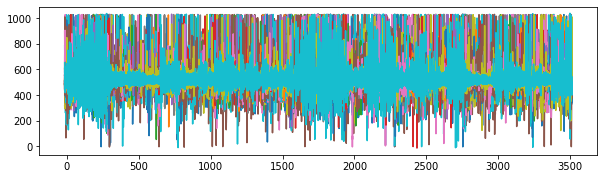

In [22]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(211)
df_sig.plot(ax=ax,legend = False)
plt.show()

In [67]:
def backplot(concert_event_times,concert_event_types,event_palette,y_range,ax = ax):
    # function to add type-wise background colours to plots based on information in concert_times
    event_times = concert_event_times
    time_start =  event_times[0]-5
    event_types = concert_event_types
    ax.margins(0)
    for ev in event_palette.keys():
        ax.axvspan(time_start,time_start+5,0,1, facecolor=event_palette[ev],label=ev,hatch = event_hatching[ev],edgecolor="w",)
    ax.legend()#fontsize = 8)

    for i in range(len(event_times)-1):
        et = event_types[i]
        ei= event_times.iloc[i]
        ej = event_times.iloc[i+1]
        ax.axvspan(ei,ej,y_range[0],y_range[1], facecolor=event_palette[et],label=et,hatch = event_hatching[et],edgecolor="w",)
    return

# Plot data

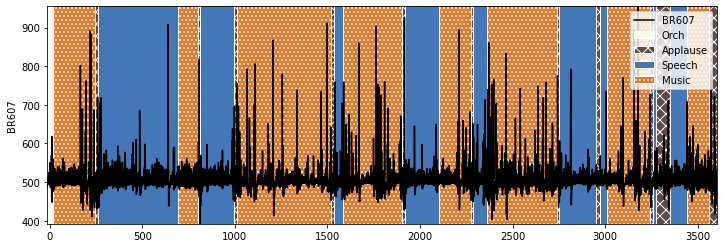

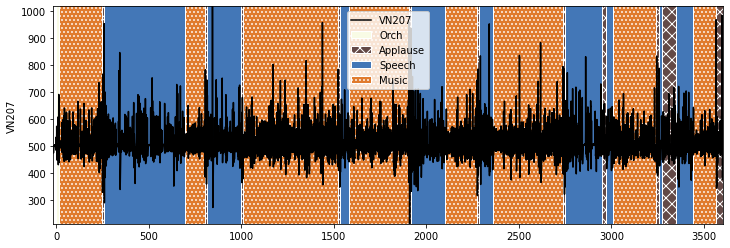

In [68]:
event_times = C_times[concert]
event_types = C_times['Event_Type']
event_palette = {'Orch':(0.972,0.984,0.8980),'Applause':(0.388,0.286,0.275),'Speech':(0.263,0.467,0.718),'Music':(0.878,0.482,0.180)}
event_hatching = {'Orch':'', 'Applause':'xx', 'Speech':'', 'Music':'...'}
y_range = [0,1024]

parts = df_sig.columns
for p in ['BR607','VN207']:
    fig, (ax) = plt.subplots(1, 1,figsize = [12,4])
    df_sig[p].plot(color='k',ax = ax)
    ax.set_ylabel(p)
    backplot(event_times,event_types,event_palette,y_range,ax = ax)
    plt.show()

Start with LS403, isolating intervals of presumably quiet breathing and active respiration.

Text(0.5, 1.0, 'C5 Applause for Reich respiration by VN207')

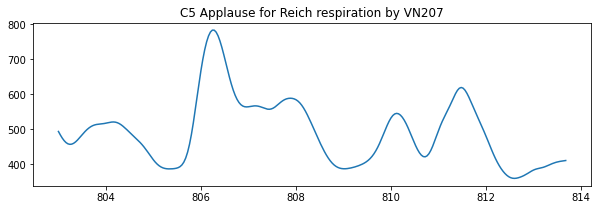

In [69]:
ev_n = 5
p = 'VN207'
df_sig.loc[C_times.loc[ev_n,concert]:C_times.loc[ev_n+1,concert],p].plot(figsize = (10,3))
plt.title(concert + ' ' + C_times.loc[ev_n,'Event'] + ' respiration by ' + p)

In [70]:
Comps = ['Inspiration_Onset', 'Expiration_Onset', 'Inspiration_high',
       'Expiration_high','Post_Expiration']
windows = {'Inspiration_Onset':0.5, 'Expiration_Onset':0.5, 'Inspiration_high':0.2,
       'Expiration_high':0.2,'Post_Expiration':0.2}

scale_high=0.5
scale_low = 0.3

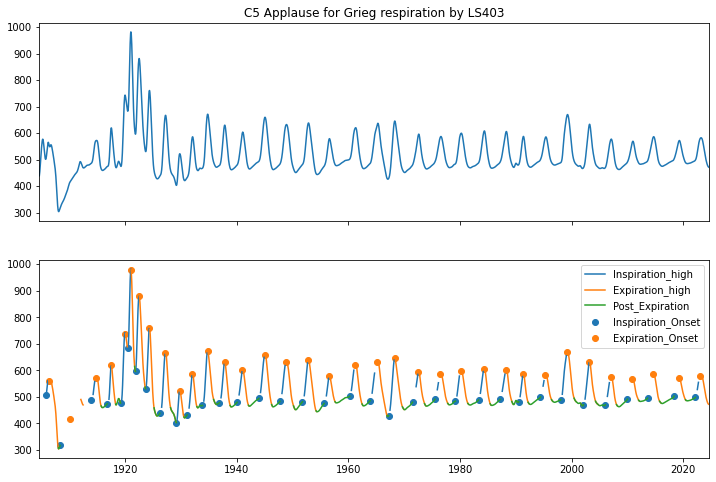

In [71]:
p = 'LS403'
ev_n = 12
sample_dur = 120
sig = df_sig.loc[C_times.loc[ev_n,concert]:C_times.loc[ev_n,concert]+sample_dur,p]
respPhases = respy.Resp_phases(sig,scale_high, scale_low)  # trying 0.6, 0.4 instead of 0.7,0.3

fig, axs = plt.subplots(2,1, sharex='all',figsize=(12,8))
ax = axs[0]
sig.plot(ax=ax)
plt.xlim(C_times.loc[ev_n,concert],C_times.loc[ev_n+1,concert]) 
ax.set_title(concert + ' ' + C_times.loc[ev_n,'Event'] + ' respiration by ' + p)

ax = axs[1]
CP = respPhases.loc[respPhases['Inspiration_Onset']==1,'Signal']
ax.scatter(x = CP.index,y = CP.values,label = 'Inspiration_Onset')
respPhases['Inspiration_high'].plot(ax=ax)
CP = respPhases.loc[respPhases['Expiration_Onset']==1,'Signal']
ax.scatter(x = CP.index,y = CP.values,label = 'Expiration_Onset')
respPhases['Expiration_high'].plot(ax=ax)
respPhases['Post_Expiration'].plot(ax=ax)

plt.legend()
plt.xlim(C_times.loc[ev_n,concert],C_times.loc[ev_n,concert]+sample_dur) 
plt.savefig('_'.join(['phase_components',p,concert,str(ev_n),'.png']),dpi = 300)
plt.show()

In [50]:
#Breaths = respy.Breath_Features(df_sig.loc[C_times.loc[ev_n,concert]:C_times.loc[ev_n+1,concert],p],filtered=True)
Breaths = respy.Breath_Features(df_sig.loc[C_times.loc[0,concert]:C_times.loc[C_times.Event=='End',concert].values[0],p],filtered=True)

# Breaths.iloc[-10:,:]
Breaths[Breaths['Insp_T']==Breaths['Insp_T'].quantile(interpolation='nearest')].iloc[0]


In          1379.053000
Ex          1379.773000
Depth        153.515426
Insp_T         0.720000
Period_T       1.880000
Exp_T          1.160000
IE_Ratio       0.620690
Insp_V       213.215870
Exp_V        132.340885
Name: 431, dtype: float64

In [51]:
C_times.loc[C_times.Event=='End',concert].values[0]

3756.436

In [52]:
C_times.loc[0,concert]:C_times.loc[C_times.Event=='End',concert]

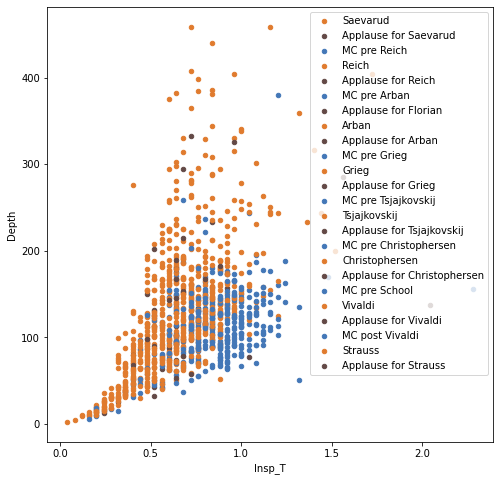

In [53]:
#Breaths.iloc[-10:,:]
med_breaths = pd.DataFrame(columns = Breaths.keys())
fig, (ax) = plt.subplots(1, 1,figsize = [8,8])
for ev_n in range(2,len(C_times)-1):
    Breaths = respy.Breath_Features(df_sig.loc[C_times.loc[ev_n,concert]:C_times.loc[ev_n+1,concert],p],filtered=True)
    med_breaths.loc[C_times.loc[ev_n,'Event'],:]= Breaths[Breaths['Insp_T']==Breaths['Insp_T'].quantile(interpolation='nearest')].iloc[0]
    Breaths.plot.scatter(x = 'Insp_T', y = 'Depth',label= C_times.loc[ev_n,'Event'],color = event_palette[C_times.loc[ev_n,'Event_Type']], ax = ax)
plt.legend()
plt.show()

First try normalising by quiet breathing, taking the median depth of the median length inspiration, which for wind players who breath more rarely during active play, will be from the times between. 

OR I could consider only the time between...

Median for not playing time? 

In [55]:
insp_t_bin = np.linspace(0,1.5,30,endpoint=True)
depth_bin = np.linspace(0,600,30,endpoint=True)

AttributeError: 'DataFrame' object has no attribute 'Insp_T'

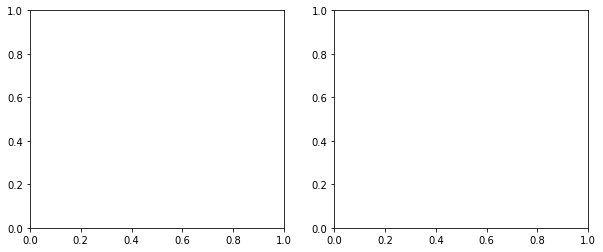

In [58]:
#p = 'VN203'
#p = 'LS403'
# Breaths = respy.Breath_Features(df_sig.loc[C_times.loc[0,concert]:C_times.loc[29,concert],p],filtered=True)
# A = plt.hist2d(Breaths.Insp_T,Breaths.Depth, bins=(insp_t_bin,depth_bin), cmap=plt.cm.jet)
# plt.show()
fig, ax = plt.subplots(1, 2,figsize = [10,4])

Q_Breaths = pd.DataFrame()
for ev_n in range(2,len(C_times)-1):
    sigsnip = df_sig.loc[C_times.loc[ev_n,concert]:C_times.loc[ev_n+1,concert],p]
    #print([ev_n,sigsnip.diff().abs().mean()])
    if sigsnip.diff().abs().mean()>1: # cut out lost signal segments
        if C_times.loc[ev_n,'Event_Type']=='Speech':
            Breaths = respy.Breath_Features(sigsnip,filtered=True)
            Q_Breaths = pd.concat([Q_Breaths,Breaths],axis=0)
counts, xedges, yedges, im = ax[0].hist2d(Q_Breaths.Insp_T,Q_Breaths.Depth, bins=(insp_t_bin,depth_bin), cmap=plt.cm.jet)
fig.colorbar(im, ax=ax[0])
ax[0].set_title('Listening to Speech breaths ' + p)
ax[0].set_xlabel('Inspiration Time')
ax[0].set_ylabel('Depth')
M_Breaths = pd.DataFrame()
for ev_n in range(2,len(C_times)-1):
    sigsnip = df_sig.loc[C_times.loc[ev_n,concert]:C_times.loc[ev_n+1,concert],p]
    #print([ev_n,sigsnip.diff().abs().mean()])
    if sigsnip.diff().abs().mean()>0.3:
        if C_times.loc[ev_n,'Event_Type']=='Music':
            Breaths = respy.Breath_Features(sigsnip,filtered=True)
            M_Breaths = pd.concat([M_Breaths,Breaths],axis=0)
counts, xedges, yedges, im = ax[1].hist2d(M_Breaths.Insp_T,M_Breaths.Depth, bins=(insp_t_bin,depth_bin), cmap=plt.cm.jet)

fig.colorbar(im, ax=ax[1])
ax[1].set_title('Music playing breaths ' + p)
ax[1].set_xlabel('Inspiration Time')

plt.savefig('_'.join(['./plots/Resp_raw',p,'param.jpg']),bbox_inches = 'tight',dpi = 200)
plt.close()

<AxesSubplot:xlabel='Insp_T', ylabel='Depth'>

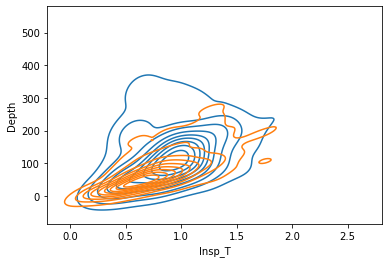

In [119]:
# https://www.python-graph-gallery.com/2d-density-plot/?utm_content=cmp-trueplt.hist2d(x, y, bins=(50, 50), cmap=plt.cm.jet)
Breaths = respy.Breath_Features(df_sig.loc[C_times.loc[0,concert]:C_times.loc[29,concert],p],filtered=True)
#sns.kdeplot(x=Breaths.Insp_T, y=Breaths.Depth)
sns.kdeplot(x=Q_Breaths.Insp_T, y=Q_Breaths.Depth)
sns.kdeplot(x=M_Breaths.Insp_T, y=M_Breaths.Depth)

In theory, breaths while listening that have the same period should have around the same depth. 

Per participant during these waiting periods, pull out median inspiration depth, inspiration duration, and period duration

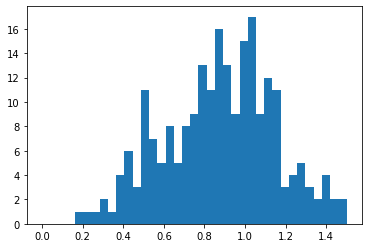

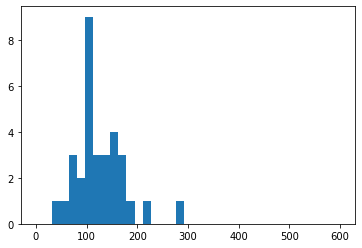

[0.972972972972973,
 1.0540540540540542,
 0.9199999999999591,
 105.40540540540542,
 113.80847759790737]

In [120]:
# Extract the range of breaths with median duration during non-music 
# take the median depth of that set, and set it to one.
V = plt.hist(Q_Breaths.Insp_T, bins=insp_t_bin)
plt.show()
B = Q_Breaths.loc[Q_Breaths.Insp_T>V[1][V[0].argmax()-1],:].copy()
B = B.loc[B.Insp_T<V[1][V[0].argmax()+1],:].copy()
C = plt.hist(B.Depth, bins=depth_bin)
plt.show()
[V[1][V[0].argmax()-1],V[1][V[0].argmax()+1],Q_Breaths.Insp_T.median(),(C[1][C[0].argmax()]+C[1][C[0].argmax()+1])/2,B.Depth.median()]

In [121]:
V = np.histogram(Q_Breaths.Insp_T, bins=insp_t_bin)
B = Q_Breaths.loc[Q_Breaths.Insp_T>V[1][V[0].argmax()-1],:].copy()
B = B.loc[B.Insp_T<V[1][V[0].argmax()+1],:].copy()
C = np.histogram(B.Depth, bins=depth_bin)
[V[1][V[0].argmax()-1],V[1][V[0].argmax()+1],Q_Breaths.Insp_T.median(),(C[1][C[0].argmax()]+C[1][C[0].argmax()+1])/2,B.Depth.median()]

[0.972972972972973,
 1.0540540540540542,
 0.9199999999999591,
 105.40540540540542,
 113.80847759790737]

It looks like we can get a stable value per participant for thier "quiet breathing" by picking the most common breath durations during not-playing conditions and then from there to most common inspiration durations. If this common quiet breath depth is set to one, what happens to their depth of inspirations elsewhere?

## Normalise by common quiet inspiration depth

In [30]:
df_filtsig = df_sig.copy()

In [31]:
insp_t_bin = np.linspace(0,1.5,int(1.5*sf)+1,endpoint=True)
depth_bin = np.linspace(0,600,int(1.5*sf)+1,endpoint=True)

In [32]:
df_scaledSig = df_filtsig.copy()
for p in df_scaledSig.columns:
    # pull out the breaths while the MC is talking
    Q_Breaths = pd.DataFrame()
    for ev_n in range(2,len(C_times)-1):
        sigsnip = df_scaledSig.loc[C_times.loc[ev_n,concert]:C_times.loc[ev_n+1,concert],p]
        if sigsnip.diff().abs().mean()>0.3: # cut out lost signal segments
            if C_times.loc[ev_n,'Event_Type']=='Speech':
                Breaths = respy.Breath_Features(sigsnip,filtered=True)
                Q_Breaths = pd.concat([Q_Breaths,Breaths],axis=0)

    if len(Q_Breaths)>100:     
        V = np.histogram(Q_Breaths.Insp_T, bins=insp_t_bin)
        B = Q_Breaths.loc[Q_Breaths.Insp_T>V[1][V[0].argmax()-1],:].copy()
        B = B.loc[B.Insp_T<V[1][V[0].argmax()+1],:].copy()
        C = np.histogram(B.Depth, bins=depth_bin)
        #[V[1][V[0].argmax()-1],V[1][V[0].argmax()+1],Q_Breaths.Insp_T.median(),(C[1][C[0].argmax()]+C[1][C[0].argmax()+1])/2,B.Depth.median()]
        scaling_C = (C[1][C[0].argmax()]+C[1][C[0].argmax()+1])/2
        df_scaledSig.loc[:,p] = df_scaledSig.loc[:,p] /scaling_C
    else:
        df_scaledSig.loc[:,p] = np.nan


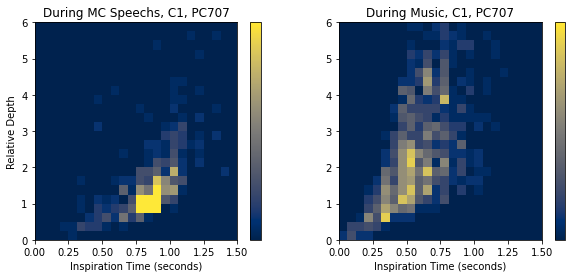

In [33]:
insp_t_bin = np.linspace(0,1.5,25,endpoint=True)
scale_depth_bin = np.linspace(0,6,25,endpoint=True)

p = 'PC707'
df_sig = df_scaledSig.copy()
# Breaths = respy.Breath_Features(df_sig.loc[C_times.loc[0,concert]:C_times.loc[29,concert],p],filtered=True)
# A = plt.hist2d(Breaths.Insp_T,Breaths.Depth, bins=(insp_t_bin,depth_bin), cmap=plt.cm.jet)
# plt.show()
fig, ax = plt.subplots(1, 2,figsize = [10,4])

Q_Breaths = pd.DataFrame()
for ev_n in range(2,len(C_times)-1):
    #if not C_times.loc[ev_n,'Event_Type']=='Music':
    if C_times.loc[ev_n,'Event_Type']=='Speech':
        Breaths = respy.Breath_Features(df_sig.loc[C_times.loc[ev_n,concert]:C_times.loc[ev_n+1,concert],p],filtered=True)
        Q_Breaths = pd.concat([Q_Breaths,Breaths],axis=0)
counts, xedges, yedges, im = ax[0].hist2d(Q_Breaths.Insp_T,Q_Breaths.Depth, bins=(insp_t_bin,scale_depth_bin),  vmin = 0, vmax = 20,cmap='cividis')
cbar = fig.colorbar(im, ax=ax[0])
cbar.set_ticks([])
ax[0].set_title('During MC Speechs, '+concert+', ' + p)
ax[0].set_xlabel('Inspiration Time (seconds)')
ax[0].set_ylabel('Relative Depth')

M_Breaths = pd.DataFrame()
for ev_n in range(2,len(C_times)-1):
    if C_times.loc[ev_n,'Event_Type']=='Music':
        Breaths = respy.Breath_Features(df_sig.loc[C_times.loc[ev_n,concert]:C_times.loc[ev_n+1,concert],p],filtered=True)
        M_Breaths = pd.concat([M_Breaths,Breaths],axis=0)
counts, xedges, yedges, im = ax[1].hist2d(M_Breaths.Insp_T,M_Breaths.Depth, bins=(insp_t_bin,scale_depth_bin), vmin = 0, vmax = 20, cmap='cividis')
cbar = fig.colorbar(im, ax=ax[1])
cbar.set_ticks([])
ax[1].set_title('During Music, '+concert+', ' + p)
ax[1].set_xlabel('Inspiration Time (seconds)')

plt.savefig('_'.join(['./plots/Resp_Parms/Insp',p,concert,'_dists.jpg']),bbox_inches = 'tight',dpi = 200)
plt.show()

In [34]:
insp_t_bin = np.linspace(0,1.5,25,endpoint=True)
scale_depth_bin = np.linspace(0,6,25,endpoint=True)

for p in df_sig.columns:
#p = 'PC707'
    df_sig = df_scaledSig.copy()
    # Breaths = respy.Breath_Features(df_sig.loc[C_times.loc[0,concert]:C_times.loc[29,concert],p],filtered=True)
    # A = plt.hist2d(Breaths.Insp_T,Breaths.Depth, bins=(insp_t_bin,depth_bin), cmap=plt.cm.jet)
    # plt.show()
    fig, ax = plt.subplots(1, 2,figsize = [10,4])

    Q_Breaths = pd.DataFrame()
    for ev_n in range(2,len(C_times)-1):
        #if not C_times.loc[ev_n,'Event_Type']=='Music':
        if C_times.loc[ev_n,'Event_Type']=='Speech':
            Breaths = respy.Breath_Features(df_sig.loc[C_times.loc[ev_n,concert]:C_times.loc[ev_n+1,concert],p],filtered=True)
            Q_Breaths = pd.concat([Q_Breaths,Breaths],axis=0)
    counts, xedges, yedges, im = ax[0].hist2d(Q_Breaths.Insp_T,Q_Breaths.Depth, bins=(insp_t_bin,scale_depth_bin),  vmin = 0, vmax = 20,cmap='cividis')
    cbar = fig.colorbar(im, ax=ax[0])
    cbar.set_ticks([])
    ax[0].set_title('During MC Speechs, '+concert+', ' + p)
    ax[0].set_xlabel('Inspiration Time (seconds)')
    ax[0].set_ylabel('Relative Depth')

    M_Breaths = pd.DataFrame()
    for ev_n in range(2,len(C_times)-1):
        if C_times.loc[ev_n,'Event_Type']=='Music':
            Breaths = respy.Breath_Features(df_sig.loc[C_times.loc[ev_n,concert]:C_times.loc[ev_n+1,concert],p],filtered=True)
            M_Breaths = pd.concat([M_Breaths,Breaths],axis=0)
    counts, xedges, yedges, im = ax[1].hist2d(M_Breaths.Insp_T,M_Breaths.Depth, bins=(insp_t_bin,scale_depth_bin), vmin = 0, vmax = 20, cmap='cividis')
    cbar = fig.colorbar(im, ax=ax[1])
    cbar.set_ticks([])
    ax[1].set_title('During Music, '+concert+', ' + p)
    ax[1].set_xlabel('Inspiration Time (seconds)')

    plt.savefig('_'.join(['./plots/Resp_Parms/Insp',p,concert,'_dists.jpg']),bbox_inches = 'tight',dpi = 200)
    plt.close()
#     plt.show()

In [96]:
df_scaledSig

,VN102,VN107,VN108,VN101,VN105,VN103,VN104,VN205,VN203,VN206,...,BR606,BR607,BR605,BR601,PC704,PC705,PC703,PC701,PC702,PC707
-15.000,5.500445,22.925618,6.382487,16.829607,4.077272,4.336188,5.071107,8.548691,12.333726,6.756338,...,11.790130,61.176492,13.243381,21.295365,9.493528,62.654731,6.322674,20.631571,11.741160,5.096997
-14.960,5.489419,22.597238,6.278786,16.869645,4.135249,4.343756,4.976822,8.542279,12.259457,6.744054,...,11.802427,61.292194,13.272109,21.301261,9.330976,62.687172,6.436728,20.671966,11.734280,5.107933
-14.920,5.478359,22.277899,6.177035,16.893390,4.208319,4.351212,4.885375,8.537392,12.187268,6.732385,...,11.815187,61.404154,13.291687,21.306517,9.173708,62.716870,6.542052,20.710657,11.727572,5.119650
-14.880,5.467353,21.974848,6.079137,16.882702,4.311752,4.358563,4.799110,8.535087,12.118936,6.721740,...,11.828818,61.509227,13.295344,21.310703,9.025918,62.739981,6.630335,20.745934,11.721467,5.132669
-14.840,5.456405,21.693899,5.986819,16.822785,4.457116,4.365906,4.719635,8.535804,12.055792,6.712272,...,11.843554,61.605504,13.280556,21.313844,8.890493,62.752796,6.695220,20.776381,11.716546,5.147266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3395.494,5.724409,21.014356,6.422862,15.706953,5.427565,4.619643,5.598687,8.493538,12.691716,7.257182,...,12.101611,63.935340,15.048576,20.918463,9.884796,54.987963,6.554063,20.879429,12.134134,2.846316
3395.534,5.707227,20.734435,6.480635,15.870756,5.554445,4.624072,5.617164,8.529143,12.668004,7.307259,...,12.041456,63.486372,15.008737,20.916002,9.923135,54.819631,6.639605,20.816083,12.157125,2.870461
3395.574,5.687417,20.465738,6.536654,15.924365,5.672790,4.628952,5.638776,8.571866,12.654780,7.362323,...,11.991190,63.054867,14.950472,20.916831,9.945178,54.661955,6.713287,20.756205,12.184671,2.893344
3395.614,5.666237,20.216797,6.591199,15.899780,5.784136,4.634101,5.663041,8.620252,12.649843,7.421607,...,11.947669,62.634017,14.879253,20.919708,9.953686,54.512495,6.778214,20.698342,12.216211,2.915393


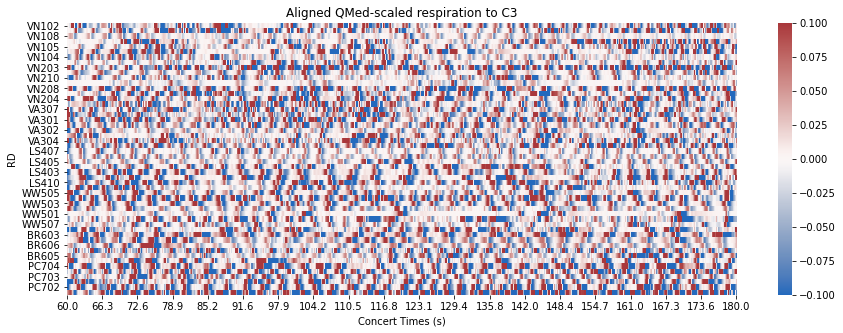

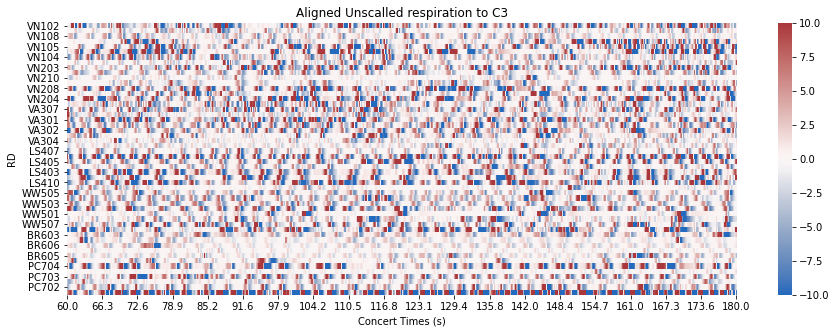

In [97]:
fig, (ax) = plt.subplots(1, 1,figsize = [15,5])

df_sig = df_scaledSig.loc[60:180,:].diff().copy()
times = df_sig.index
num_ticks = 20
xticks = np.linspace(0, len(times) - 1, num_ticks, dtype='int')
xticklabels = [np.round(times[idx],1) for idx in xticks]

chart = sns.heatmap(data=df_sig.transpose(),vmin=-0.1, vmax=0.1, ax=ax,cmap="vlag")
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,rotation = 0)
ax.set_ylabel(concert)
ax.set_title('Aligned QMed-scaled respiration to C3')

ax.set_xlabel('Concert Times (s)')
#plt.savefig('./plots/2_performances_'+ piece_name+ '_set_'+sigName+'.png',dpi = 300)
plt.show()

fig, (ax) = plt.subplots(1, 1,figsize =[15,5])

df_sig = df_filtsig.loc[60:180,:].diff().copy()
times = df_sig.index
num_ticks = 20
xticks = np.linspace(0, len(times) - 1, num_ticks, dtype='int')
xticklabels = [np.round(times[idx],1) for idx in xticks]

chart = sns.heatmap(data=df_sig.transpose(),vmin=-10, vmax=10, ax=ax,cmap="vlag")
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,rotation = 0)
ax.set_ylabel(concert)
ax.set_title('Aligned Unscalled respiration to C3')

ax.set_xlabel('Concert Times (s)')
#plt.savefig('./plots/2_performances_'+ piece_name+ '_set_'+sigName+'.png',dpi = 300)
plt.show()

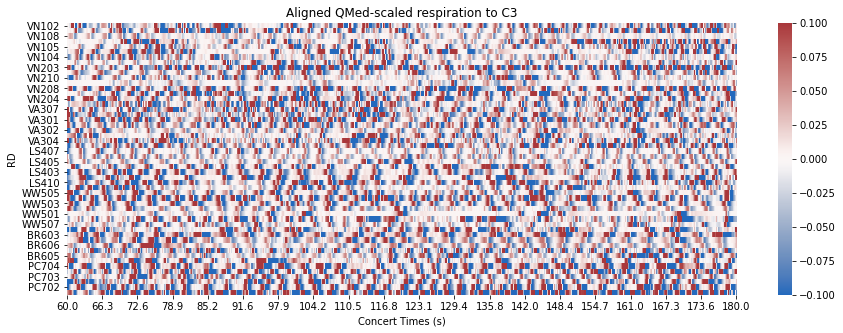

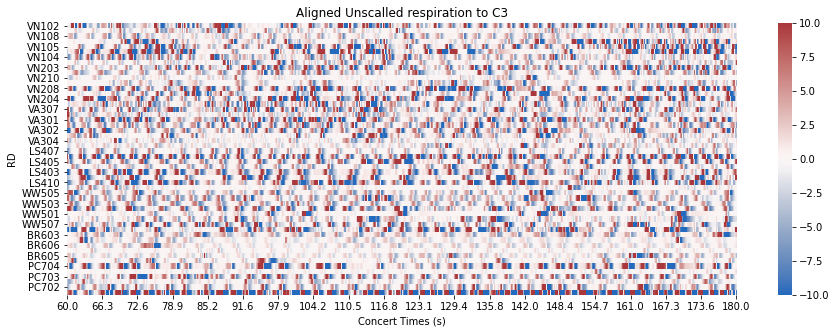

In [98]:
fig, (ax) = plt.subplots(1, 1,figsize = [15,5])

df_sig = df_scaledSig.loc[60:180,:].diff().copy()
times = df_sig.index
num_ticks = 20
xticks = np.linspace(0, len(times) - 1, num_ticks, dtype='int')
xticklabels = [np.round(times[idx],1) for idx in xticks]

chart = sns.heatmap(data=df_sig.transpose(),vmin=-0.1, vmax=0.1, ax=ax,cmap="vlag")
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,rotation = 0)
ax.set_ylabel(concert)
ax.set_title('Aligned QMed-scaled respiration to C3')

ax.set_xlabel('Concert Times (s)')
#plt.savefig('./plots/2_performances_'+ piece_name+ '_set_'+sigName+'.png',dpi = 300)
plt.show()

fig, (ax) = plt.subplots(1, 1,figsize = [15,5])

df_sig = df_filtsig.loc[60:180,:].diff().copy()
times = df_sig.index
num_ticks = 20
xticks = np.linspace(0, len(times) - 1, num_ticks, dtype='int')
xticklabels = [np.round(times[idx],1) for idx in xticks]

chart = sns.heatmap(data=df_sig.transpose(),vmin=-10, vmax=10, ax=ax,cmap="vlag")
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,rotation = 0)
ax.set_ylabel(concert)
ax.set_title('Aligned Unscalled respiration to C3')

ax.set_xlabel('Concert Times (s)')
#plt.savefig('./plots/2_performances_'+ piece_name+ '_set_'+sigName+'.png',dpi = 300)
plt.show()

# Scalling works!
It might not be perfect, there are some signals that are still a bit faint but this scaling by quiet breaths during quiet stage time does improve the visibility of respiration for many. Lets save these results.

In [167]:
datafile_type = 'EQRESP'
concert = 'C5'
piece = 'Full'
data_loc = '../Data/AlignedEQ/20230218_C5/' + piece + '/'
files = os.listdir(data_loc)
files.sort()
sig_files = {}
for f in files: 
    if f.endswith(datafile_type+'.csv'): 
        partID = f.split('_')[2]
        sig_files[partID] = data_loc+f
        
sigName = 'Breathing'
C_times = Piece_timings[['Event','Event_Type','Related',concert]].sort_values(concert)
C_times = C_times.loc[C_times[concert]>-15,:].reset_index(drop = True).copy()
C_times

,Event,Event_Type,Related,C5
0,Synch Taps,Orch,Init,0.000
1,Saevarud,Music,Saev,15.336
2,Applause for Saevarud,Applause,Saev,246.166
3,MC pre Reich,Speech,Reic,257.826
4,Reich,Music,Reic,694.972
5,Applause for Reich,Applause,Reic,802.967
6,MC pre Arban,Speech,Arba,813.700
7,Applause for Florian,Applause,Arba,997.015
8,Arban,Music,Abra,1012.486
9,Applause for Arban,Applause,Abra,1520.986


In [168]:
sf = 25 # hz 
cutoff = 2 #cutoff = np.array([0.05,1]) 
nyq = 0.5 * sf 
order = 2 
normal_cutoff = cutoff / nyq
b, a = butter(order, normal_cutoff, btype='lowpass', analog=False)

s_time = -15 #C_times.loc[0,concert]
e_time = C_times[concert].iloc[-1]
dur = e_time - s_time
time_s = s_time +  np.round(np.linspace(0,dur,int(sf*(dur)),endpoint=False),3)

df_sig = pd.DataFrame(index = time_s,columns = Players_Resp[concert],dtype='float')


In [169]:
for partID in Players_Resp[concert]:
    V = pd.read_csv(sig_files[partID])
    sig_t = V['c_sTime']
    sig_v = V[sigName]
    f = interpolate.interp1d(sig_t, sig_v,fill_value='extrapolate')
    new_sig = f(time_s)
    y = filtfilt(b, a, new_sig)
    df_sig.loc[:,partID] = y

df_filtsig = df_sig.copy()

df_scaledSig = df_filtsig.copy()
for p in df_scaledSig.columns:
    # pull out the breaths while the MC is talking
    Q_Breaths = pd.DataFrame()
    for ev_n in range(2,len(C_times)-1):
        if C_times.loc[ev_n,'Event_Type']=='Speech':
            sig = df_scaledSig.loc[C_times.loc[ev_n,concert]:C_times.loc[ev_n+1,concert],p]
            if sig.diff().abs().mean()>0.3:
                Breaths = respy.Breath_Features(sig,filtered=True)
                Q_Breaths = pd.concat([Q_Breaths,Breaths],axis=0)
    if len(Q_Breaths)>100:     
        V = np.histogram(Q_Breaths.Insp_T, bins=insp_t_bin)
        B = Q_Breaths.loc[Q_Breaths.Insp_T>V[1][V[0].argmax()-1],:].copy()
        B = B.loc[B.Insp_T<V[1][V[0].argmax()+1],:].copy()
        C = np.histogram(B.Depth, bins=depth_bin)
        #[V[1][V[0].argmax()-1],V[1][V[0].argmax()+1],Q_Breaths.Insp_T.median(),(C[1][C[0].argmax()]+C[1][C[0].argmax()+1])/2,B.Depth.median()]
        scaling_C = (C[1][C[0].argmax()]+C[1][C[0].argmax()+1])/2
        df_scaledSig.loc[:,p] = df_scaledSig.loc[:,p] /scaling_C
    else:
        df_scaledSig.loc[:,p] = np.nan

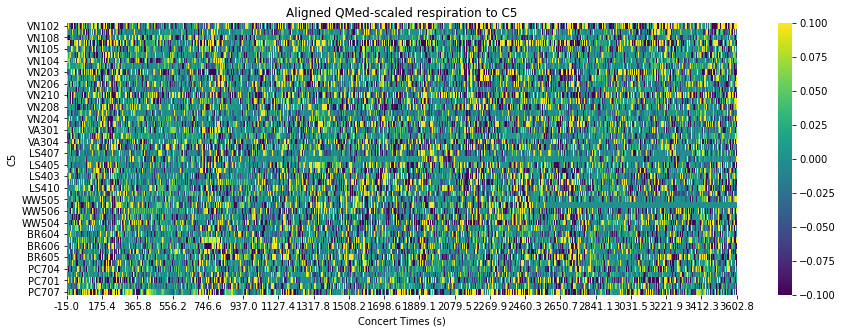

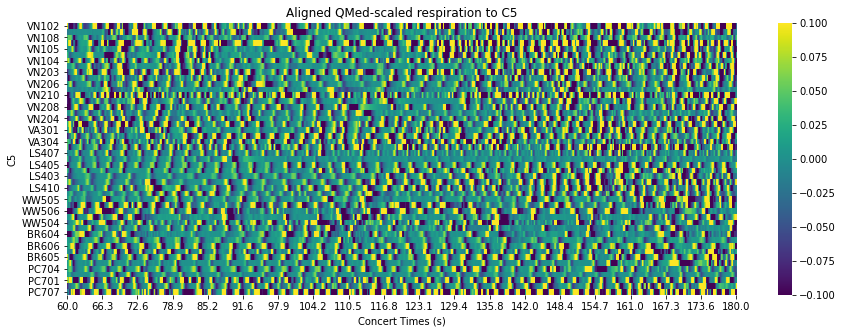

In [170]:
fig, (ax) = plt.subplots(1, 1,figsize = [15,5])

df_sig = df_scaledSig.diff().copy()
times = df_sig.index
num_ticks = 20
xticks = np.linspace(0, len(times) - 1, num_ticks, dtype='int')
xticklabels = [np.round(times[idx],1) for idx in xticks]

chart = sns.heatmap(data=df_sig.transpose(),vmin=-0.1, vmax=0.1, ax=ax,cmap="viridis")
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,rotation = 0)
ax.set_ylabel(concert)
ax.set_title('Aligned QMed-scaled respiration to ' + concert)
ax.set_xlabel('Concert Times (s)')
plt.savefig('./plots/Full_Scaled_Resp_'+concert+'.png',dpi = 300)
plt.show()

fig, (ax) = plt.subplots(1, 1,figsize = [15,5])

df_sig = df_scaledSig.loc[60:180,:].diff().copy()
times = df_sig.index
num_ticks = 20
xticks = np.linspace(0, len(times) - 1, num_ticks, dtype='int')
xticklabels = [np.round(times[idx],1) for idx in xticks]

chart = sns.heatmap(data=df_sig.transpose(),vmin=-0.1, vmax=0.1, ax=ax,cmap="viridis")
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,rotation = 0)
ax.set_ylabel(concert)
ax.set_title('Aligned QMed-scaled respiration to ' + concert)
ax.set_xlabel('Concert Times (s)')
plt.savefig('./plots/Exc_Scaled_Resp_'+concert+'.png',dpi = 300)
plt.show()

In [171]:
df_scaledSig.to_csv('../Data/Respiration/'+concert + '_Full_Scaled_Respiration.csv')